# Print the selected tokens

### Single Labels: print selected token

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch
from functools import partial
import os
from termcolor import colored
from tqdm import tqdm 

def encode_with_prompt_completion_format(example, tokenizer, max_seq_length, add_bos=False):
    '''
    Here we assume each example has 'prompt' and 'completion' fields.
    We concatenate prompt and completion and tokenize them together because otherwise prompt will be padded/trancated 
    and it doesn't make sense to follow directly with the completion.
    '''
    # if prompt doesn't end with space and completion doesn't start with space, add space
    if not example['prompt'].endswith((' ', '\n', '\t')) and not example['completion'].startswith((' ', '\n', '\t')):
        example_text = example['prompt'] + ' ' + example['completion']
    else:
        example_text = example['prompt'] + example['completion']
    example_text = example_text + tokenizer.eos_token
    if add_bos:
        example_text = tokenizer.bos_token + example_text
    tokenized_example = tokenizer(example_text, return_tensors='pt', max_length=max_seq_length, truncation=True)
    input_ids = tokenized_example.input_ids
    labels = input_ids.clone()
    tokenized_prompt = tokenizer(example['prompt'], return_tensors='pt', max_length=max_seq_length, truncation=True)
    # mask the prompt part for avoiding loss
    # labels[:, :tokenized_prompt.input_ids.shape[1]] = -100
    attention_mask = torch.ones_like(input_ids)
    return {
        'input_ids': input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': attention_mask.flatten(),
    }

def encode_with_messages_format(example, tokenizer, max_seq_length, add_bos=False):
    '''
    Here we assume each example has a 'messages' field Each message is a dict with 'role' and 'content' fields.
    We concatenate all messages with the roles as delimiters and tokenize them together.
    '''
    messages = example['messages']
    if len(messages) == 0:
        raise ValueError('messages field is empty.')
    
    def _concat_messages(messages):
        message_text = ""
        for message in messages:
            if message["role"] == "system":
                message_text += "<|system|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "user":
                message_text += "<|user|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "assistant":
                message_text += "<|assistant|>\n" + message["content"].strip() + tokenizer.eos_token + "\n"
            else:
                raise ValueError("Invalid role: {}".format(message["role"]))
        return message_text
        
    example_text = _concat_messages(messages).strip()
    if add_bos:
        example_text = tokenizer.bos_token + example_text
    tokenized_example = tokenizer(example_text, return_tensors='pt', max_length=max_seq_length, truncation=True)
    input_ids = tokenized_example.input_ids
    labels = input_ids.clone()

    # mask the non-assistant part for avoiding loss
    for message_idx, message in enumerate(messages):
        if message["role"] != "assistant":
            if message_idx == 0:
                message_start_idx = 0
            else:
                message_start_idx = tokenizer(
                    _concat_messages(messages[:message_idx]), return_tensors='pt', max_length=max_seq_length, truncation=True
                ).input_ids.shape[1]
            if message_idx < len(messages) - 1 and messages[message_idx+1]["role"] == "assistant":
                # here we also ignore the role of the assistant
                messages_so_far = _concat_messages(messages[:message_idx+1]) + "<|assistant|>\n"
            else:
                messages_so_far = _concat_messages(messages[:message_idx+1])
            message_end_idx = tokenizer(
                messages_so_far,
                return_tensors='pt', 
                max_length=max_seq_length, 
                truncation=True
            ).input_ids.shape[1]
            # labels[:, message_start_idx:message_end_idx] = -100

            if message_end_idx >= max_seq_length:
                break

    attention_mask = torch.ones_like(input_ids)
    return {
        'input_ids': input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': attention_mask.flatten(),
    }

def encode_data(raw_dataset):
    
    if "prompt" in raw_dataset["train"].column_names and "completion" in raw_dataset["train"].column_names:
        encode_function = partial(
            encode_with_prompt_completion_format,
            tokenizer=tokenizer,
            max_seq_length= 2048,
            add_bos= False,
        )
    elif "messages" in raw_dataset["train"].column_names:
        encode_function = partial(
            encode_with_messages_format,
            tokenizer=tokenizer,
            max_seq_length= 2048,
            add_bos= False,
        )
        
            
    lm_datasets = raw_dataset.map(
        encode_function,
        batched=False,
        # remove_columns=[name for name in raw_dataset["train"].column_names if name not in ["idx", "input_ids", "labels", "attention_mask"]],
        desc="Tokenizing and reformatting instruction data",
    )

    return lm_datasets['train']['labels']
    
###############################################

model_name_or_path = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)


# train_dataset_tag="filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered"

train_dataset_tag="filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered-fixed-base-model"
# train_dataset_tag= "filtered-cured-50k-rho-baseline-llama3b-global"

## the print example for illustration

label_path = 'results/label/'
data_path = f"selected_data/"

text_all_files = {}
for idx in range(1,5):
    

    cur_model_label_file = f'token_labels_{train_dataset_tag}' + "_" + str(idx) + '.pt'
    # fixed_base_model_label_file =  f'token_labels_{train_dataset_tag_fixed_base_loss}' + "_" + str(idx) + '.pt' 
    
    cur_orig_data = train_dataset_tag + "_" + str(idx) + '.json'
    
    raw_dataset = load_dataset("json", data_files= data_path + cur_orig_data)
    
    orig_labels_all = encode_data(raw_dataset)

    cur_train_model_labels_all = torch.load(label_path + cur_model_label_file, weights_only=False)
    # fixed_base_model_labels_all = torch.load(label_path + fixed_base_model_label_file, weights_only=False)

    text_all = []
    all_token_count = sum([len(labels_per_sample) for labels_per_sample in orig_labels_all])
    all_token_count_response = sum(1 for labels_per_sample in orig_labels_all for label in labels_per_sample if label != -100)
    
    cur_train_label_count = sum([1 for row in cur_train_model_labels_all for label in row if label != -100])
    # fixed_base_label_count = sum([1 for row in fixed_base_model_labels_all for label in row if label != -100])
    
    print_text_example_count=10

    cur_train_model_label_count = 0
    for cur_train_model_labels, orig_labels in tqdm(zip(cur_train_model_labels_all, orig_labels_all), desc="handing each sample"):
        text = []
        for cur_label, orig_label in zip(cur_train_model_labels, orig_labels):
            if orig_label != -100:
                token = tokenizer.decode([orig_label], skip_special_tokens=True)  
                if cur_label != -100:
                    # text.append(colored(token, 'blue'))
                    text.append(f"\\textcolor{{blue}}{{{token.replace(' ', '~')}}}")
                    cur_train_model_label_count += 1
                else:
                    text.append(token)
                    
        text_single = "".join(text)

        if print_text_example_count > 0:
            # print('*' * 100 + f"Round {idx}" + '*' * 100)
            print('#' * 200 + '\n')
            print(text_single)
            text_all.append(text_single)

        print_text_example_count -= 1
        
        
    text_all_files[idx] = text_all

    print("#" * 80)
    print(f"cur_train_model_label_count selected token proportion: {round(cur_train_model_label_count/all_token_count_response * 100, 2)}%")

    print("#" * 80)



handing each sample: 76it [00:00, 334.48it/s]

########################################################################################################################################################################################################

<|user|>
What is the meaning of "real life"? How does one distinguish the real world from the imaginary? Can virtual reality experiences be considered real life? How do our senses interpret reality?
<|assistant|>
\textcolor{blue}{The}\textcolor{blue}{~meaning}\textcolor{blue}{~of}\textcolor{blue}{~"}\textcolor{blue}{real}\textcolor{blue}{~life}\textcolor{blue}{"}\textcolor{blue}{~can} be\textcolor{blue}{~subjective}\textcolor{blue}{~and}\textcolor{blue}{~varies}\textcolor{blue}{~from}\textcolor{blue}{~person}\textcolor{blue}{~to} person\textcolor{blue}{.}\textcolor{blue}{~Generally}\textcolor{blue}{,}\textcolor{blue}{~it} refers to experiences and interactions\textcolor{blue}{~that} occur\textcolor{blue}{~in} the physical\textcolor{blue}{~world}\textcolor{blue}{,}\textcolor{blue}{~as}\te

handing each sample: 10000it [00:29, 342.95it/s]


################################################################################
cur_train_model_label_count selected token proportion: 39.35%
################################################################################


handing each sample: 68it [00:00, 331.80it/s]

########################################################################################################################################################################################################

<|user|>
As a customer experience analyst at a popular clothing store chain, you are tasked with developing a multifaceted strategy to maximize profits. To achieve this objective, you must identify the most profitable items by considering various factors such as sales performance and profit margins. Furthermore, you need to devise a comprehensive approach to increase sales by determining the optimal mix of shirts, pants, and dresses that will generate the most revenue. However, you have to work within a set of constraints such as limited advertising budget and display space, which may impact your decision-making process. Can you use your analytical skills to calculate the optimal mix of items that will maximize profits while accounting for all these constraints?
<|assistant|>
\textcolor{

handing each sample: 10000it [00:28, 348.73it/s]


################################################################################
cur_train_model_label_count selected token proportion: 40.3%
################################################################################


handing each sample: 66it [00:00, 324.18it/s]

########################################################################################################################################################################################################

<|user|>
Could you provide a comprehensive analysis of all notable occurrences in Silmarillion, the Lord of the Rings books, and the Hobbit book, including the exact years when each ring was created, the consequences of each time Sauron was defeated, and the ages of key characters involved? Also, please include a detailed timeline of these significant events and the primary locations where they took place. To guarantee accuracy, please utilize both primary and secondary sources, as well as data analysis techniques to construct your timeline.
<|assistant|>
Providing\textcolor{blue}{~a}\textcolor{blue}{~comprehensive}\textcolor{blue}{~analysis}\textcolor{blue}{~of} all\textcolor{blue}{~notable}\textcolor{blue}{~occurrences}\textcolor{blue}{~in}\textcolor{blue}{~Sil}\textcolor{blue}{mar}\te

handing each sample: 10000it [00:27, 368.18it/s]


################################################################################
cur_train_model_label_count selected token proportion: 41.17%
################################################################################


handing each sample: 84it [00:00, 420.23it/s]

########################################################################################################################################################################################################

<|user|>
As a legal expert, I understand your need for a comprehensive and binding legal document that covers all aspects of a bathroom renovation project. However, have you considered the environmental impact of the materials and processes used in the renovation? 

My rare prompt for you is to create a legal document that not only covers safety, warranties, and payment terms, but also outlines the use of environmentally-friendly materials and processes in the renovation. This document should ensure that all materials and processes used comply with relevant regulations and standards, while also being sustainable and eco-friendly. Additionally, it should address any potential disputes that may arise related to the environmental impact of the renovation and how they will be resolved.

With

handing each sample: 10000it [00:24, 406.20it/s]

################################################################################
cur_train_model_label_count selected token proportion: 42.97%
################################################################################


## Show the results in Latex file

In [6]:
import os
import re
def remove_ansi(text):
    """去除 ANSI 颜色控制字符"""
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

def save_texts_to_latex(text_all_files, output_filename="tokenized_output_self_evolving_model_cleaning.tex"):
    latex_header = r"""\documentclass{article}
    \usepackage{xcolor}
    \usepackage{tcolorbox}
    \usepackage{lipsum}
    \begin{document}
    """
    latex_footer = r"\end{document}"
    
    content = [latex_header]
    
    for idx, texts in text_all_files.items():
        content.append(f"\\section*{{Text Collection {idx}}}")
        content.append("\n\n\n")

        for text_num, text_list in enumerate(texts, start=1):
            latex_text = "".join([
                # f"\\textcolor{{blue}}{{{token[0].replace(' ', '~')}}}" if isinstance(token, tuple) and token[1] == "blue" else token
                # f"\\textcolor{{blue}}{{{remove_ansi(token[0]).replace(' ', '~')}}}" if isinstance(token, tuple) and token[1] == "blue" else remove_ansi(token)
                    token
                for token in text_list
            ])
            
            # 转义 LaTeX 特殊字符
            # latex_text = latex_text.replace("\\", "\\textbackslash{}")  # 处理反斜杠
            latex_text = latex_text.replace("%", "\\%")  # 处理 %
            latex_text = latex_text.replace("&", "\\&")  # 处理 &
            latex_text = latex_text.replace("_", "\\_")  # 处理 _
            latex_text = latex_text.replace("#", "\\#")  # 处理 #
            
            content.append(r"\begin{tcolorbox}[colframe=black,colback=white]")
            content.append("\n")
            content.append(latex_text)
            content.append("\n")
            content.append(r"\end{tcolorbox}")
            content.append("\n\n\n")

    
    content.append(latex_footer)
    
    with open(output_filename, "w", encoding="utf-8") as f:
        f.writelines(content)
    
    print(f"LaTeX file saved to {output_filename}")

# 调用函数并保存 LaTeX 文件
save_texts_to_latex(text_all_files)


LaTeX file saved to tokenized_output_self_evolving_model_cleaning.tex


## Check the loss difference under the iter split pattern

In [22]:
import torch
import numpy as np
import os

loss_path = "results/loss/"
label_path = "results/label/"
base_model = "meta-llama/Llama-3.2-3B"

train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop"
num_subset=5
# results/loss/token_losses_filtered-cured-50k-iter-split-global_data_prop_1_lora_merged_filtered-cured-50k-iter-split-global_data_prop_0.pt

for idx in range(1, num_subset):
    ##pre model's loss
    if idx < 2:
        base_model_name=os.path.basename(base_model)
        losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_model_name}.pt")
    else:
        base_model_name=f"lora_merged_{train_dataset_tag}"
        losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_model_name}_{idx-2}.pt")

    ### reference model's loss
    ref_model_name=f"lora_merged_{train_dataset_tag}"
    losses_cur = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{ref_model_name}_{idx-1}.pt")


    selected_labels_all = torch.load(f"results/label/token_labels_{train_dataset_tag}_{idx}.pt")           
    loss_diff_all = [(np.array(loss1) - np.array(loss2)).tolist() for loss1, loss2 in zip(losses_pre, losses_cur)]


    selected_labels_count = 0

    selected_labels_loss_diff = []
    for row_labels, row_loss_diff in zip(selected_labels_all, loss_diff_all):
        for label, loss_diff_value in zip(row_labels, row_loss_diff):
            if label != -100:
                selected_labels_loss_diff.append(loss_diff_value)
                selected_labels_count += 1
                
                
    negative_loss_labels_count = sum([1 for loss_diff in selected_labels_loss_diff if loss_diff < 0])

    loss_average = np.mean(selected_labels_loss_diff)

    print(f"negative loss proportion under selected tokens: {round(negative_loss_labels_count/selected_labels_count * 100, 2)} %")


/tmp/ipykernel_3122953/2285754465.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_mod

negative loss proportion under selected tokens: 0.0 %


/tmp/ipykernel_3122953/2285754465.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_mod

negative loss proportion under selected tokens: 0.0 %
negative loss proportion under selected tokens: 0.0 %
negative loss proportion under selected tokens: 0.0 %


FileNotFoundError: [Errno 2] No such file or directory: 'results/loss/token_losses_filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered-fixed-base-model_1_lora_merged_filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered-fixed-base-model_0.pt'

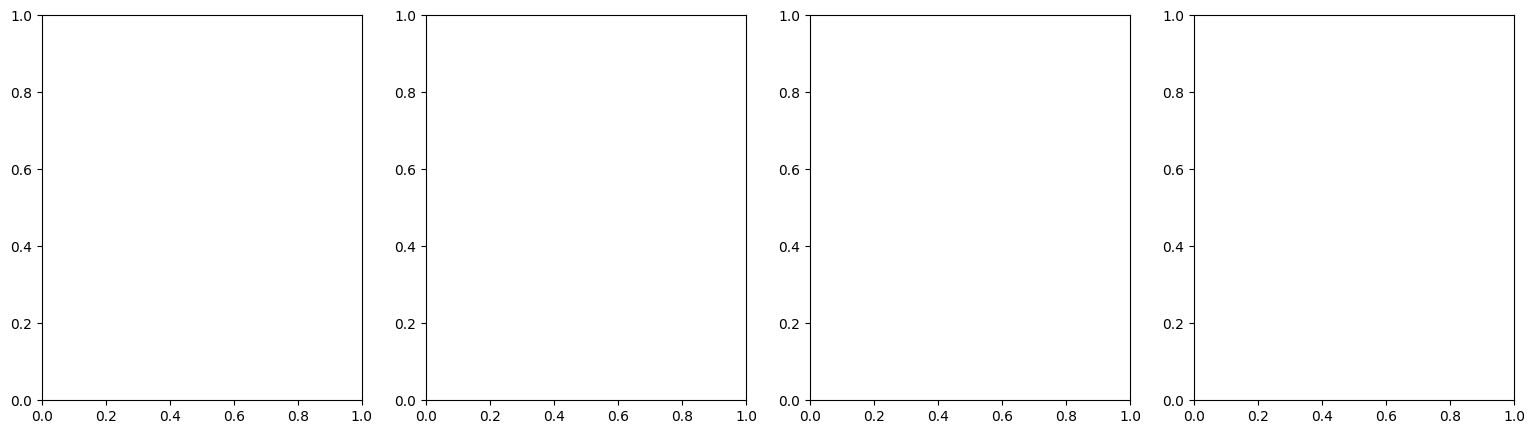

In [24]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt



loss_path = "results/loss/"
label_path = "results/label/"
base_model = "meta-llama/Llama-3.2-3B"

train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b"
data_prop=0.6

subset_size = 5

additional_train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered-fixed-base-model"


# 创建一个大的图形框架
# fig, axes = plt.subplots(1, subset_size, figsize=(5 * subset_size, 4))

fig, axes = plt.subplots(1, subset_size-1, figsize=(4 * subset_size-1, 5))

for idx in range(1, subset_size):
    ##pre model's loss
    if idx < 2:
        base_model_name=os.path.basename(base_model)
        losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_model_name}.pt")
    else:
        base_model_name=f"lora_merged_{train_dataset_tag}"
        losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_model_name}_{idx-2}.pt")

    ### reference model's loss
    ref_model_name=f"lora_merged_{train_dataset_tag}"
    losses_cur = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{ref_model_name}_{idx-1}.pt")

    selected_labels_all = torch.load(f"results/label/token_labels_{train_dataset_tag}_{idx}.pt")           

    additional_selected_labels_all =  torch.load(f"results/label/token_labels_{additional_train_dataset_tag}_{idx}.pt")   
            
    flattened_selected_labels = []
    for row_labels in selected_labels_all:
        flattened_selected_labels.extend(row_labels)
        
    select_global_tokens_indices = []
    for i, label in enumerate(flattened_selected_labels):
        if label != -100:
            select_global_tokens_indices.append(i)
            
    flattened_additional_selected_labels = []
    for row_labels in additional_selected_labels_all:
        flattened_additional_selected_labels.extend(row_labels)
        
    additional_select_global_tokens_indices = []
    for i, label in enumerate(flattened_additional_selected_labels):
        if label != -100:
            additional_select_global_tokens_indices.append(i)
            

    input_pre = [value for sublist in losses_pre for value in sublist]
    input_cur = [value for sublist in losses_cur for value in sublist]

    # losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_pre, input_cur)]
    # select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))


    selected_pre = [input_pre[i] for i in select_global_tokens_indices]
    selected_cur = [input_cur[i] for i in select_global_tokens_indices]

    all_indices = set(range(len(input_pre)))
    additional_selected_set = set(additional_select_global_tokens_indices)
    additional_unselected_indices = list(all_indices - additional_selected_set)

    # 获取未被选中的 token 的 loss
    additional_unselected_pre = [input_pre[i] for i in additional_unselected_indices]
    additional_unselected_cur = [input_cur[i] for i in additional_unselected_indices]
    additional_selected_pre = [input_pre[i] for i in additional_select_global_tokens_indices]
    additional_selected_cur = [input_cur[i] for i in additional_select_global_tokens_indices]

    print(f"token selection proportion ({idx-1}): {round(len(additional_selected_pre)/ len(input_pre) * 100, 2)} %")

    ax = axes[idx-1] 

    # 绘制散点图
    ax.scatter(input_cur, input_pre, c='lightblue', s=1, alpha=0.5)#, label='Orginal Tokens'
    # ax.scatter(selected_cur, selected_pre, c='salmon', s=1, label="Iter Pattern Selected Tokens", alpha=0.7)
    ax.scatter(additional_selected_cur, additional_selected_pre, c='blue', s=1, label="Informative Tokens", alpha=0.7)

    ax.scatter(additional_unselected_cur, additional_unselected_pre, c='red', s=1, label="Uninformative Tokens", alpha=0.7)

    # 添加标题和标签
    ax.set_title(f"Iteration-{idx}",fontsize=18)
    ax.set_xlabel(f"Reference model loss",fontsize=18)

    # 绘制对角线 y = x
    min_val = min(min(input_cur), min(input_pre))
    max_val = max(max(input_cur), max(input_pre))
    ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')

    # x_vals = np.linspace(min_val, max_val, 500)
    # y_vals = 1.2 * x_vals + 3
    # ax.plot(x_vals, y_vals, color='black', linestyle='-', label='y = 1.2x +3')
    # ax.set_xscale('log')
    # ax.set_yscale('log')  

    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    if idx ==1:
        ax.legend(fontsize=16, markerscale=5, loc='lower right')
        ax.set_ylabel(f"Base model loss",fontsize=18)

    
plt.tight_layout()
plt.show()

# token_infl_score

### Plot the selected token distribution under iter split pattern

FileNotFoundError: [Errno 2] No such file or directory: 'results/loss/token_losses_filtered-cured-50k-active-split-global-curve-positive-reverse-loss-sum_0_Llama-3.2-3B.pt'

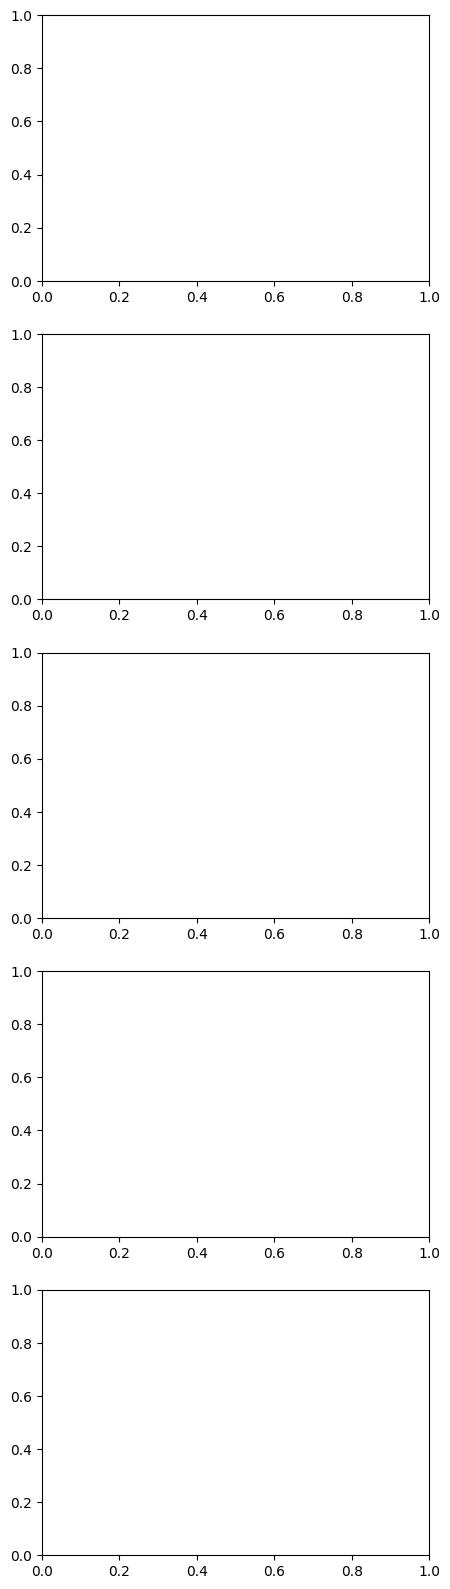

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):
    flattened = [(value, idx) for idx, value in enumerate(data)]
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k]  ##loss
    top_k_indices = [item[1] for item in top_k]
    return top_k_indices


def get_half_positive_indices(data):
    selected_flattened = [(value, idx) for idx, value in enumerate(data) if value > 0]
    top_half_positive = sorted(selected_flattened, key=lambda x: x[0], reverse=True)[:int(len(selected_flattened)/2)] ##loss

    top_half_positive_indices = [item[1] for item in top_half_positive]
    return top_half_positive_indices

def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 2
    beta = 0.07
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta and sample_losses_cur <5: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices


# Data and training parameters
###################################################
loss_path="results/loss/"
ref_model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
base_model_name_or_path = "meta-llama/Llama-3.2-3B"


# dataset_name="filtered-cured-50k-iter-split-global-curve-positive-new1" 
# dataset_name="filtered-cured-50k-iter-split-token-ranking-sample"
dataset_name="filtered-cured-50k-active-split-global-curve-positive-reverse-loss-sum"
ref_dataset_name = "filtered-cured-50k-active-split-global-curve-positive-new1"

# dataset_name="filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss"

subset_size = 5 # 增加子集数量以绘制多个子图
data_prop = 0.6

ref_model_name = os.path.basename(ref_model_name_or_path)

# 创建一个大的图形框架
# fig, axes = plt.subplots(1, subset_size, figsize=(5 * subset_size, 4))

fig, axes = plt.subplots(subset_size, 1, figsize=( 5, 4 * subset_size))


for idx in range(subset_size):
    dataset_name_tag = f"{dataset_name}_{idx}"
    ref_dataset_name_tag = f"{ref_dataset_name}_{idx}"
    ref_model_name = ref_dataset_name_tag
    if idx == 0:
        cur_train_model_name = os.path.basename(base_model_name_or_path)
        cur_train_model_tag = os.path.basename(base_model_name_or_path)
        cur_ref_train_model_name =  os.path.basename(base_model_name_or_path)
    else:
        cur_train_model_name = f"lora_merged_{dataset_name}_{idx-1}"
        cur_ref_train_model_name = f"lora_merged_{ref_dataset_name}_{idx-1}"
        cur_train_model_tag = f"{idx}th-iteration training model"
        
    losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
    losses_ref = torch.load(f"results/loss/token_losses_{ref_dataset_name_tag}_{cur_ref_train_model_name}.pt")
    
    input_cur_train = [value for sublist in losses_cur_train for value in sublist]
    input_ref = [value for sublist in losses_ref for value in sublist]

    # 计算两个模型的损失差异
    losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_cur_train, input_ref)]

    all_token_count = sum(len(losses) for losses in losses_ref)
    print(f"#### all token counting: {all_token_count}\n")

    print(f"Dataset: {dataset_name_tag} -- Token proportion with positive loss diff : {round(sum(1 for loss in losses_diff if loss > 0) / len(losses_diff) * 100, 2)}%")

    select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))
    # select_global_tokens_indices = get_half_positive_indices(losses_diff)
    # select_global_tokens_indices = get_curve_positive_indices(input_cur_train, input_ref)
    print(f"Dataset: {dataset_name_tag} -- selected Token proportion with positive loss diff: {round(len(select_global_tokens_indices) / len(losses_diff) * 100, 2)}%")

    # 选择合适的子图
    ax = axes[idx]  # 选择对应的子图轴

    # 绘制散点图
    ax.scatter(input_ref, input_cur_train, c='lightblue', s=1, alpha=0.5, label='Orginal Tokens')

    selected_train = [input_cur_train[i] for i in select_global_tokens_indices]
    selected_ref = [input_ref[i] for i in select_global_tokens_indices]
    ax.scatter(selected_ref, selected_train, c='salmon', s=1, label="Selected Tokens", alpha=0.7)

    # 添加标题和标签
    ax.set_title(f"{dataset_name_tag}")
    ax.set_xlabel(f"{ref_model_name} Losses")
    ax.set_ylabel(f"{cur_train_model_tag} Losses")

    # 绘制对角线 y = x
    min_val = min(min(input_cur_train), min(input_ref))
    max_val = max(max(input_cur_train), max(input_ref))
    ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')

    # x_vals = np.linspace(min_val, max_val, 500)
    # y_vals = 1.2 * x_vals + 3
    # ax.plot(x_vals, y_vals, color='black', linestyle='-', label='y = 1.2x +3')
    # ax.set_xscale('log')  # 如果你想要对 x 轴应用对数尺度
    # ax.set_yscale('log')  # 如果你想要对 y 轴应用对数尺度
    
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    # 显示图例
    ax.legend(fontsize=12, markerscale=5, loc='lower right')

# 调整图形布局
plt.tight_layout()

# 显示所有子图
plt.show()


## Final Token Influence Score Vistualization

base model: meta-llama/Llama-3.1-8B
the minimum influence score value of informative tokens is 0.0005744122572650667
the minimum influence score value of informative tokens is 0.000910413233214058
the minimum influence score value of informative tokens is 0.0008733008335184422
the minimum influence score value of informative tokens is 0.0007496613634430105


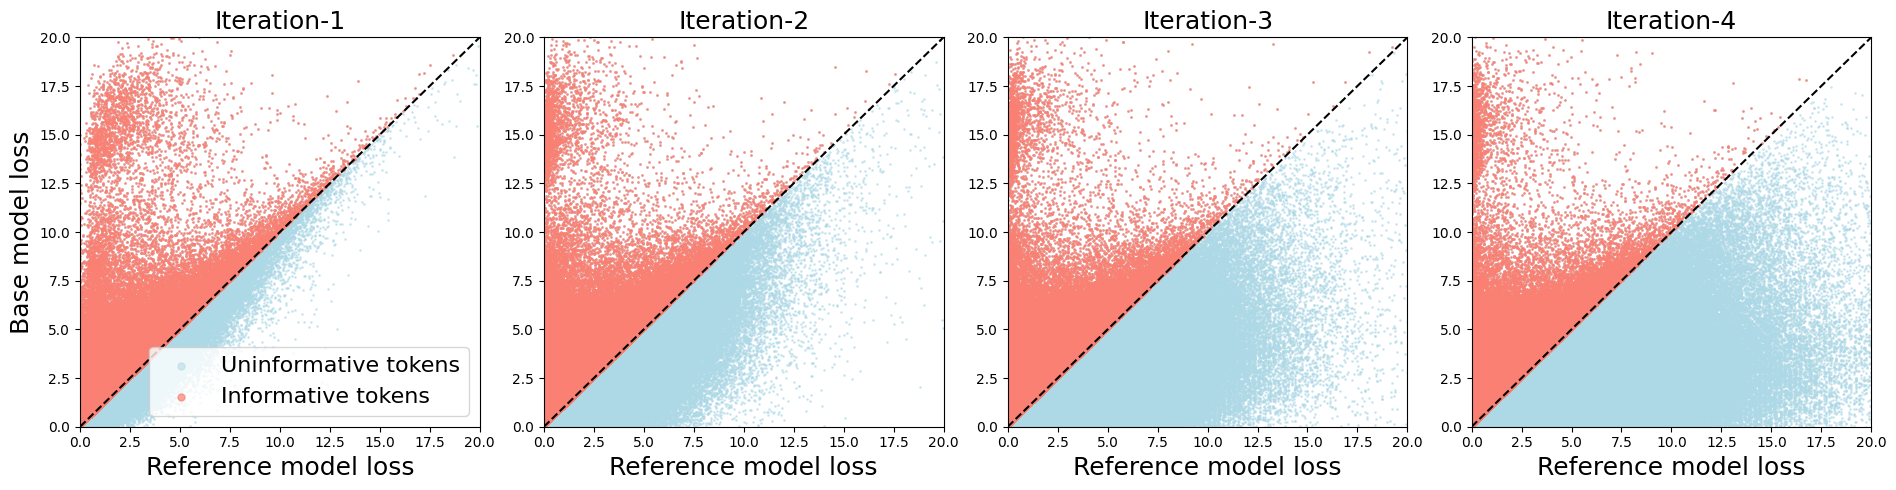

In [20]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt



loss_path = "results/loss/"
label_path = "results/label/"

data_prop=0.6
subset_size = 5

#llama-3b
# base_model = "meta-llama/Llama-3.2-3B"
# warmup_model_tag = "filtered-cured-10k-warmup-llama3b"
# train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop_0.6_llama3b-non-filtered-fixed-base-model"

#llama-8b
base_model = "meta-llama/Llama-3.1-8B"
warmup_model_tag = "filtered-cured-10k-warmup-llama8b"
train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop_0.6_llama8b-non-filtered-fixed-base-model"


#llama-8b
# base_model = "mistralai/Mistral-7B-v0.3"
# warmup_model_tag = "filtered-cured-10k-warmup-mistral"
# train_dataset_tag = "filtered-cured-50k-iter-split-global_data_prop_0.6_mistral-non-filtered-fixed-base-model"


print(f"base model: {base_model}")

# 创建一个大的图形框架
# fig, axes = plt.subplots(1, subset_size, figsize=(5 * subset_size, 4))

fig, axes = plt.subplots(1, subset_size-1, figsize=(4 * subset_size-1, 5))

for idx in range(1, subset_size):
    ##pre model's loss
    base_model_name=os.path.basename(base_model)
    losses_pre = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{base_model_name}.pt")
    if idx < 2:
        ### reference model's loss
        ref_model_name=f"lora_merged_{warmup_model_tag}"
        losses_cur = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{ref_model_name}.pt")
    else:
        ### reference model's loss
        ref_model_name=f"lora_merged_{train_dataset_tag}"
        losses_cur = torch.load(loss_path + f"token_losses_{train_dataset_tag}_{idx}_{ref_model_name}_{idx-1}.pt")

    selected_labels_all = torch.load(f"results/label/token_labels_{train_dataset_tag}_{idx}.pt")           

    flattened_selected_labels = []
    for row_labels in selected_labels_all:
        flattened_selected_labels.extend(row_labels)
        
    select_global_tokens_indices = []
    for i, label in enumerate(flattened_selected_labels):
        if label != -100:
            select_global_tokens_indices.append(i)
            

    input_pre = [value for sublist in losses_pre for value in sublist]
    input_cur = [value for sublist in losses_cur for value in sublist]

    selected_pre = [input_pre[i] for i in select_global_tokens_indices]
    selected_cur = [input_cur[i] for i in select_global_tokens_indices]


    selected_infl_scores = [s1 - s2 for s1, s2 in zip(selected_pre, selected_cur)]
    # print(f"token selection proportion ({idx-1}): {round(len(selected_pre)/ (len(input_pre)-input_pre.count(0.0)) * 100, 2)} %")
    print(f"the minimum influence score value of informative tokens is {min(selected_infl_scores)}")

    ax = axes[idx-1] 

    # 绘制散点图
    ax.scatter(input_cur, input_pre, c='lightblue', s=1, alpha=0.5, label='Uninformative tokens')
    ax.scatter(selected_cur, selected_pre, c='salmon', s=1, label="Informative tokens", alpha=0.7)

    # 添加标题和标签
    ax.set_title(f"Iteration-{idx}",fontsize=18)
    ax.set_xlabel(f"Reference model loss",fontsize=18)

    # 绘制对角线 y = x
    min_val = min(min(input_cur), min(input_pre))
    max_val = max(max(input_cur), max(input_pre))
    ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    if idx ==1:
        ax.legend(fontsize=16, markerscale=5, loc='lower right')
        ax.set_ylabel(f"Base model loss",fontsize=18)

    
plt.tight_layout()
plt.show()

# token_infl_score